# Feature Engineering / Data Cleaning / Model Training
In dieser Datei werden weitere Features gebaut, um das Modell zu verbessern. Weiter wird der Datensatz gesäubert und für das Training des Modells vorbereitet. Abschliessend werden verschiedene Modelle trainiert und das Beste ausgegeben.

In [52]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from App.helper.functions import station_upper
import App.helper.config as config

## Feature Engineering
In dem folgenden Teil werden verschiedene Features in das Modell aufgenommen: Wetterinformationen pro Ort, Einschränkungen/Störungen auf der Strecke sowie Feiertage.
- Wetterdaten stammen aus einer Datenbank des Bundes
- Einschränkungen stammen aus Twitterinformationen
- Feiertage wurden aus einer Datei von Opendata.swiss entnommen

**Störungsinformationen hinzufügen**

In [53]:
# Read twitter data
# daten = pd.read_csv('App/Daten/data_expanded/combined_data_twitter.csv')
daten1 = pd.read_csv('App/Daten/data_new/combined_data_twitter1.csv')
daten2 = pd.read_csv('App/Daten/data_new/combined_data_twitter2.csv')
daten = pd.concat([daten1, daten2], ignore_index=True)
daten['Einschr_type'].fillna('Keine', inplace=True)
print(len(daten))
daten.head(2)

C:\Users\stoec\AppData\Local\Temp\ipykernel_3192\93135905.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  daten1 = pd.read_csv('App/Daten/data_new/combined_data_twitter1.csv')


1187177


,BETRIEBSTAG,LINIEN_ID,LINIEN_TEXT,haltestelle_an,AN_soll,AN_ist,AN_diff,haltestelle_ab,AB_soll,AB_ist,AB_diff,weekday,ab_hour,ab_minute,disturbance_overlap,Einschr_type
0,2022-06-05,2032,IR,luzern,2022-06-05 20:21:00,2022-06-05 20:20:20,-0.666667,st. gallen,2022-06-05 18:05:00,2022-06-05 18:05:32,0.533333,6,18,5,False,Keine
1,2022-06-05,2033,IR,st. gallen,2022-06-05 18:55:00,2022-06-05 18:55:18,0.300000,luzern,2022-06-05 16:39:00,2022-06-05 16:40:02,1.033333,6,16,39,False,Keine


In [54]:
# Check rows with AN_ist < AB_ist
daten = daten[daten['AN_ist'] > daten['AB_ist']]
len(daten)

988198

**Feiertage hinzufügen**

In [55]:
# read feiertage data
feiertage = pd.read_excel('App/Daten/Feiertage_Haltestellen_roh.xlsx', sheet_name='data')
# convert to datetime
feiertage['datum'] = pd.to_datetime(feiertage['datum'], format='%d.%m.%Y')
feiertage['datum'] = feiertage['datum'].dt.strftime('%Y-%m-%d')
# rename columns
feiertage = feiertage.rename(index=str, columns={"datum": "BETRIEBSTAG"})
feiertage = feiertage[['BETRIEBSTAG', 'feiertag']]
feiertage

,BETRIEBSTAG,feiertag
0,2023-01-01,Neujahrstag
1,2023-04-07,Karfreitag
2,2023-04-10,Ostermontag
3,2023-05-18,Christi Himmelfahrt
4,2023-05-29,Pfingstmontag
5,2023-08-01,Nationalfeiertag
6,2023-11-01,Allerheiligen
7,2023-12-25,Weihnachtstag
8,2023-12-26,Stephanstag


In [56]:
#add feiertage to daten
merged_df = pd.merge(daten, feiertage, on=['BETRIEBSTAG'], how='left')
merged_df.sort_values(by = 'BETRIEBSTAG', inplace=True)

In [57]:
# all rows, where feiertag is not null
# merged_df[merged_df['feiertag'].notnull()].head()

In [58]:
# read feiertage data
feiertage_2022 = pd.read_csv('App/Daten/Feiertage.csv')
# convert to datetime
feiertage_2022['Zeitstempel'] = pd.to_datetime(feiertage_2022['Zeitstempel'], format='%d/%m/%Y %H:%M')
feiertage_2022['Zeitstempel'] = feiertage_2022['Zeitstempel'].dt.strftime('%Y-%m-%d')
# rename columns
feiertage_2022 = feiertage_2022.rename(index=str, columns={"Zeitstempel": "BETRIEBSTAG", "Feiertag": "feiertag"})
feiertage_2022 = feiertage_2022[['BETRIEBSTAG','feiertag']]
feiertage_2022.head()

,BETRIEBSTAG,feiertag
0,2018-01-01,Neujahrstag
1,2018-03-30,Karfreitag
2,2018-04-02,Ostermontag
3,2018-05-10,Christi Himmelfahrt
4,2018-05-21,Pfingstmontag


In [59]:
#add feiertage to daten
merged_full = pd.merge(merged_df, feiertage_2022, on=['BETRIEBSTAG'], how='left')
merged_full.sort_values(by = 'BETRIEBSTAG', inplace=True)
merged_full.head()

,BETRIEBSTAG,LINIEN_ID,LINIEN_TEXT,haltestelle_an,AN_soll,AN_ist,AN_diff,haltestelle_ab,AB_soll,AB_ist,AB_diff,weekday,ab_hour,ab_minute,disturbance_overlap,Einschr_type,feiertag_x,feiertag_y
0,2021-06-01,2357,IR35,olten,2021-06-01 06:24:00,2021-06-01 06:24:08,0.133333,bern,2021-06-01 05:38:00,2021-06-01 05:39:01,1.016667,1,5,38,False,Keine,NaN,NaN
947,2021-06-01,1960,IR36,basel sbb,2021-06-01 08:50:00,2021-06-01 08:48:10,-1.833333,zürich hb,2021-06-01 07:36:00,2021-06-01 07:40:27,4.450000,1,7,36,False,Keine,NaN,NaN
946,2021-06-01,1251,IC3,zürich hb,2021-06-01 07:00:00,2021-06-01 07:00:18,0.300000,basel sbb,2021-06-01 06:06:00,2021-06-01 06:07:27,1.450000,1,6,6,False,Keine,NaN,NaN
945,2021-06-01,1252,IC,basel sbb,2021-06-01 22:48:00,2021-06-01 22:47:55,-0.083333,zürich hb,2021-06-01 21:36:00,2021-06-01 21:37:03,1.050000,1,21,36,False,Keine,NaN,NaN
944,2021-06-01,1253,IC3,zürich hb,2021-06-01 08:00:00,2021-06-01 08:02:47,2.783333,basel sbb,2021-06-01 07:06:00,2021-06-01 07:07:18,1.300000,1,7,6,False,Keine,NaN,NaN


In [60]:
# convert to datetime
merged_full['BETRIEBSTAG'] = pd.to_datetime(merged_full['BETRIEBSTAG'], format='%Y-%m-%d')

In [61]:
# combine feiertage_x and feiertage_y
merged_full['feiertag_x'].fillna(merged_full['feiertag_y'], inplace=True)

In [62]:
# drop feiertage_y
merged_full.drop(['feiertag_y'], axis=1, inplace=True)
# rename feiertage_x to feiertag
merged_full.rename(columns={'feiertag_x': 'feiertag'}, inplace=True)
# fill NaN values with 0
merged_full['feiertag'] = merged_full['feiertag'].fillna(0).replace('[^0]', 1, regex=True)
merged_full['feiertag'].unique()

array([0, 1], dtype=int64)

In [63]:
# overview delay sorted by delay
merged_full.sort_values(by = 'AN_diff', inplace=True, ascending=False)
merged_full.head(2)

,BETRIEBSTAG,LINIEN_ID,LINIEN_TEXT,haltestelle_an,AN_soll,AN_ist,AN_diff,haltestelle_ab,AB_soll,AB_ist,AB_diff,weekday,ab_hour,ab_minute,disturbance_overlap,Einschr_type,feiertag
662591,2022-10-06,1974,IR36,basel sbb,2022-10-06 15:48:00,2022-10-07 00:54:21,546.350000,zürich hb,2022-10-06 14:36:00,2022-10-06 14:36:43,0.716667,3,14,36,False,Keine,0
610974,2022-08-29,403,IC,zürich hb,2022-08-29 08:05:00,2022-08-29 12:34:22,269.366667,basel sbb,2022-08-29 06:45:00,2022-08-29 11:20:43,275.716667,0,6,45,False,Keine,0


In [64]:
# drop outliers with delay > 2h
merged_full.drop(merged_full[merged_full['AN_diff'] > 120].index, inplace=True)
merged_full.sort_values(by = 'AN_diff', inplace=True, ascending=False)
merged_full.head(2)

,BETRIEBSTAG,LINIEN_ID,LINIEN_TEXT,haltestelle_an,AN_soll,AN_ist,AN_diff,haltestelle_ab,AB_soll,AB_ist,AB_diff,weekday,ab_hour,ab_minute,disturbance_overlap,Einschr_type,feiertag
896103,2023-03-25,843,IC8,zürich hb,2023-03-26 01:23:00,2023-03-26 03:21:39,118.65,bern,2023-03-26 01:06:00,2023-03-26 01:07:39,1.65,5,1,6,False,Keine,0
896428,2023-03-25,843,IC8,zürich hb,2023-03-26 01:23:00,2023-03-26 03:21:39,118.65,olten,2023-03-26 01:47:00,2023-03-26 01:47:36,0.60,5,1,47,False,Keine,0


**Wetterinformationen hinzufügen**

In [65]:
# read wetter data
lugano = pd.read_csv('App/Daten/wetter_lugano.txt', delimiter=';')
lugano.rename(columns={'stn':'haltestelle_ab','time':'BETRIEBSTAG', 'fu3010d1': 'Boenspitze', 'ths2dxdv': 'Temperatur', 'rka150d0':'Niederschlag', 'ure200d0':'Luftfeuchtigkeit', 'hto000d0':'Schnee','su2000d0':'Sonnenschein', 'fhh010dx':'Wind'}, inplace=True)
# drop columns
lugano.drop(['w3p002d0','w5p002d0','w2p001d0', 'w2p002d0'], axis=1, inplace=True)
# convert to datetime
lugano['BETRIEBSTAG'] = pd.to_datetime(lugano['BETRIEBSTAG'], format='%Y%m%d')
# replace station name
lugano['haltestelle_ab'] = lugano['haltestelle_ab'].replace('LUG', 'Lugano')
# drop columns
lugano.drop(['Boenspitze', 'Sonnenschein', 'Schnee'], axis=1, inplace=True)
# read wetter data
bern = pd.read_csv('App/Daten/wetter_bern.txt', delimiter=';')
bern.rename(columns={'stn':'haltestelle_ab','time':'BETRIEBSTAG', 'fu3010d1': 'Boenspitze', 'ths2dxdv': 'Temperatur', 'rka150d0':'Niederschlag', 'ure200d0':'Luftfeuchtigkeit', 'hto000d0':'Schnee','su2000d0':'Sonnenschein', 'fhh010dx':'Wind'}, inplace=True)
# convert to datetime
bern['BETRIEBSTAG'] = pd.to_datetime(bern['BETRIEBSTAG'], format='%Y%m%d')
# replace station name
bern['haltestelle_ab'] = bern['haltestelle_ab'].replace('BER', 'Bern')
# drop columns
bern.drop(['Boenspitze', 'Sonnenschein', 'Schnee'], axis=1, inplace=True)
# read wetter data
olten = pd.read_csv('App/Daten/wetter_olten.txt', delimiter=';')
olten.rename(columns={'stn':'haltestelle_ab','time':'BETRIEBSTAG', 'fu3010d1': 'Boenspitze', 't12200ds': 'Temperatur', 'rka150d0':'Niederschlag', 'ure200d0':'Luftfeuchtigkeit', 'hto000d0':'Schnee', 'fhh010dx':'Wind'}, inplace=True)
# convert to datetime
olten['BETRIEBSTAG'] = pd.to_datetime(olten['BETRIEBSTAG'], format='%Y%m%d')
# replace station name
olten['Schnee'] = np.nan
# replace station name
olten['haltestelle_ab'] = olten['haltestelle_ab'].replace('NABHAE', 'Olten')
# drop columns
olten.drop(['Boenspitze', 'Schnee'], axis=1, inplace=True)
# read wetter data
stgallen = pd.read_csv('App/Daten/wetter_stgallen.txt', delimiter=';')
stgallen.rename(columns={'stn':'haltestelle_ab','time':'BETRIEBSTAG','t12200ds': 'Temperatur', 'rka150d0':'Niederschlag', 'ure200d0':'Luftfeuchtigkeit', 'fhh010dx':'Wind'}, inplace=True)
# convert to datetime
stgallen['BETRIEBSTAG'] = pd.to_datetime(stgallen['BETRIEBSTAG'], format='%Y%m%d')
# replace station name
stgallen['haltestelle_ab'] = stgallen['haltestelle_ab'].replace('STG', 'St. Gallen')
# read wetter data
zuerich = pd.read_csv('App/Daten/wetter_zuerich.txt', delimiter=';')
zuerich.rename(columns={'stn':'haltestelle_ab','time':'BETRIEBSTAG', 'fu3010d1': 'Boenspitze', 't12200ds': 'Temperatur', 'rka150d0':'Niederschlag', 'ure200d0':'Luftfeuchtigkeit', 'hto000d0':'Schnee','su2000d0':'Sonnenschein', 'fhh010dx':'Wind'}, inplace=True)
# convert to datetime
zuerich['BETRIEBSTAG'] = pd.to_datetime(zuerich['BETRIEBSTAG'], format='%Y%m%d')
# replace station name
zuerich['haltestelle_ab'] = zuerich['haltestelle_ab'].replace('KLO', 'Zürich HB')
# drop columns
zuerich.drop(['Boenspitze', 'Sonnenschein', 'Schnee'], axis=1, inplace=True)
# read wetter data
basel = pd.read_csv('App/Daten/wetter_basel.txt', delimiter=';')
basel.rename(columns={'stn':'haltestelle_ab','time':'BETRIEBSTAG', 'fu3010d1': 'Boenspitze', 'ths2dxdv': 'Temperatur', 'rka150d0':'Niederschlag', 'ure200d0':'Luftfeuchtigkeit', 'hto000d0':'Schnee','su2000d0':'Sonnenschein', 'fhh010dx':'Wind'}, inplace=True)
# convert to datetime
basel['BETRIEBSTAG'] = pd.to_datetime(basel['BETRIEBSTAG'], format='%Y%m%d')
# replace station name
basel['haltestelle_ab'] = basel['haltestelle_ab'].replace('BAS', 'Basel SBB')
# drop columns
basel.drop(['Boenspitze', 'Sonnenschein', 'Schnee'], axis=1, inplace=True)
# read wetter data
luzern = pd.read_csv('App/Daten/wetter_luzern.txt', delimiter=';')
luzern.rename(columns={'stn':'haltestelle_ab','time':'BETRIEBSTAG', 't12200ds': 'Temperatur', 'rka150d0':'Niederschlag', 'ure200d0':'Luftfeuchtigkeit', 'hto000d0':'Schnee', 'fhh010dx':'Wind'}, inplace=True)
# convert to datetime
luzern['BETRIEBSTAG'] = pd.to_datetime(luzern['BETRIEBSTAG'], format='%Y%m%d')
# replace station name
luzern['haltestelle_ab'] = luzern['haltestelle_ab'].replace('LUZ', 'Luzern')
# drop columns
luzern.drop(['Schnee'], axis=1, inplace=True)
#bring df's together
wetter = pd.concat([lugano, bern, olten, zuerich, basel, stgallen, luzern], ignore_index=True)
# convert to datetime
wetter['BETRIEBSTAG'] = pd.to_datetime(wetter['BETRIEBSTAG'], format='%Y-%m-%d')
wetter['BETRIEBSTAG'] = wetter['BETRIEBSTAG'].astype('datetime64[ns]')
wetter.head()

,haltestelle_ab,BETRIEBSTAG,Temperatur,Niederschlag,Luftfeuchtigkeit,Wind
0,Lugano,2022-04-01,-1.5,15.5,75.0,12.3
1,Lugano,2022-04-02,-3.2,0.0,57.8,5.7
2,Lugano,2022-04-03,-3.0,0.0,54.3,7.4
3,Lugano,2022-04-04,-3.1,1.2,70.0,3.2
4,Lugano,2022-04-05,1.9,0.0,60.3,5.4


In [66]:
wetter['Wind'] = wetter['Wind'].replace('-', 0) # when no wind there's a '-' in the data
wetter['Wind'] = wetter['Wind'].astype('float64')
wetter['Niederschlag'] = wetter['Niederschlag'].replace('-', 0) # when no rain there's a '-' in the data
wetter['Niederschlag'] = wetter['Niederschlag'].astype('float64')

## Daten vorbereiten für Modell

In [67]:
# Apply station_upper function to the column haltestelle_ab and haltestelle_an
merged_full['haltestelle_ab'] = merged_full['haltestelle_ab'].apply(station_upper)
merged_full['haltestelle_an'] = merged_full['haltestelle_an'].apply(station_upper)

# # change Einschr_type Einschränkung and Einschränkungen to Einschraenkung
merged_full['Einschr_type'] = merged_full['Einschr_type'].str.replace('Einschränkung', 'Einschraenkung')
merged_full['Einschr_type'] = merged_full['Einschr_type'].str.replace('Einschraenkungen', 'Einschraenkung')

In [68]:
#merge wetter with daten
merged_sbb_wetter = pd.merge(merged_full, wetter, on=['BETRIEBSTAG', 'haltestelle_ab'], how='left')
merged_sbb_wetter.head(2)

,BETRIEBSTAG,LINIEN_ID,LINIEN_TEXT,haltestelle_an,AN_soll,AN_ist,AN_diff,haltestelle_ab,AB_soll,AB_ist,...,weekday,ab_hour,ab_minute,disturbance_overlap,Einschr_type,feiertag,Temperatur,Niederschlag,Luftfeuchtigkeit,Wind
0,2023-03-25,843,IC8,Zürich HB,2023-03-26 01:23:00,2023-03-26 03:21:39,118.65,Bern,2023-03-26 01:06:00,2023-03-26 01:07:39,...,5,1,6,False,Keine,0,1.2,4.8,75.3,6.8
1,2023-03-25,843,IC8,Zürich HB,2023-03-26 01:23:00,2023-03-26 03:21:39,118.65,Olten,2023-03-26 01:47:00,2023-03-26 01:47:36,...,5,1,47,False,Keine,0,11.0,8.0,84.6,7.5


save dataset

In [69]:
d1 = merged_sbb_wetter.loc[len(merged_sbb_wetter)//2:]
d2 = merged_sbb_wetter.loc[:len(merged_sbb_wetter)//2]
d1.to_csv('App/Daten/data_new/combined_data_twitter_long_1.csv', index=False)
d2.to_csv('App/Daten/data_new/combined_data_twitter_long_2.csv', index=False)

In [70]:
#get dummies for haltestelle_ab and haltestelle_an
merged_sbb_wetter = pd.get_dummies(merged_sbb_wetter, columns=['haltestelle_ab', 'haltestelle_an', 'LINIEN_TEXT', 'Einschr_type'])
# find NaN values with 0
merged_sbb_wetter.isna().sum().sort_values(ascending=False).head(1)

KeyboardInterrupt: 

**Finaler Datensatz**

In [ ]:
merged_sbb_wetter.head(2)

,BETRIEBSTAG,LINIEN_ID,AN_soll,AN_ist,AN_diff,AB_soll,AB_ist,AB_diff,weekday,ab_hour,...,LINIEN_TEXT_IR35,LINIEN_TEXT_IR36,LINIEN_TEXT_IR37,LINIEN_TEXT_IR70,LINIEN_TEXT_IR75,Einschr_type_Aufgehoben:,Einschr_type_Einschraenkung,Einschr_type_Endmeldung:,Einschr_type_Keine,Einschr_type_Unterbruch
0,2023-03-25,843,2023-03-26 01:23:00,2023-03-26 03:21:39,118.65,2023-03-26 01:06:00,2023-03-26 01:07:39,1.65,5,1,...,0,0,0,0,0,0,0,0,1,0
1,2023-03-25,843,2023-03-26 01:23:00,2023-03-26 03:21:39,118.65,2023-03-26 01:47:00,2023-03-26 01:47:36,0.60,5,1,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# replace True and False with 1 and 0 in the column 'disturbance_overlap'
merged_sbb_wetter['disturbance_overlap'] = merged_sbb_wetter['disturbance_overlap'].replace(True, 1)
merged_sbb_wetter['disturbance_overlap'] = merged_sbb_wetter['disturbance_overlap'].replace(False, 0)

## Modelle trainieren
Für das Modell wurden verschiedene Regressionsmodelle getestet (XGBoost, Randomforest), diese sind gemäss Literatur die besten für vergleichbare Probleme. Das Modell wurde auf den RMSE optimiert mittels einer RandomSearchCV. Entsprechend wurden verschiedene Hyperparameter getestet und anschliessend das beste Modell exportiert.



**Vorbereiten von Daten für Modellieren**

In [ ]:
# Select columns for model
betriebstage = merged_sbb_wetter['BETRIEBSTAG']
data = merged_sbb_wetter.drop(['BETRIEBSTAG', 'AN_soll', 'AN_ist', 'AB_soll', 'AB_ist', 'AB_diff', 'LINIEN_ID'], axis=1)
data.drop_duplicates(inplace=True)

# Defne X and y
X = data.drop('AN_diff', axis=1)
y = data['AN_diff']

**Random Forest Regressor**

In [ ]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4153)


# Instantiate RandomForestRegressor
rf = RandomForestRegressor()

# Fit model
rf.fit(X_train, y_train)

# Predict y
y_pred = rf.predict(X_test)

# Calculate R2, RMSE and MAPE
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R2: {r2:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}')

# Plot y_test and y_pred
plt.scatter(y_test, y_pred, alpha=0.1, color='red')
plt.xlabel('y_test')
plt.ylabel('y_pred')
# Calculate y_min and y_max
y_min = min(y_test.min(), y_pred.min())
y_max = max(y_test.max(), y_pred.max())
# Add line with x=y with y_min and y_max
plt.plot([y_min, y_max], [y_min, y_max], color='black')
plt.show()

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

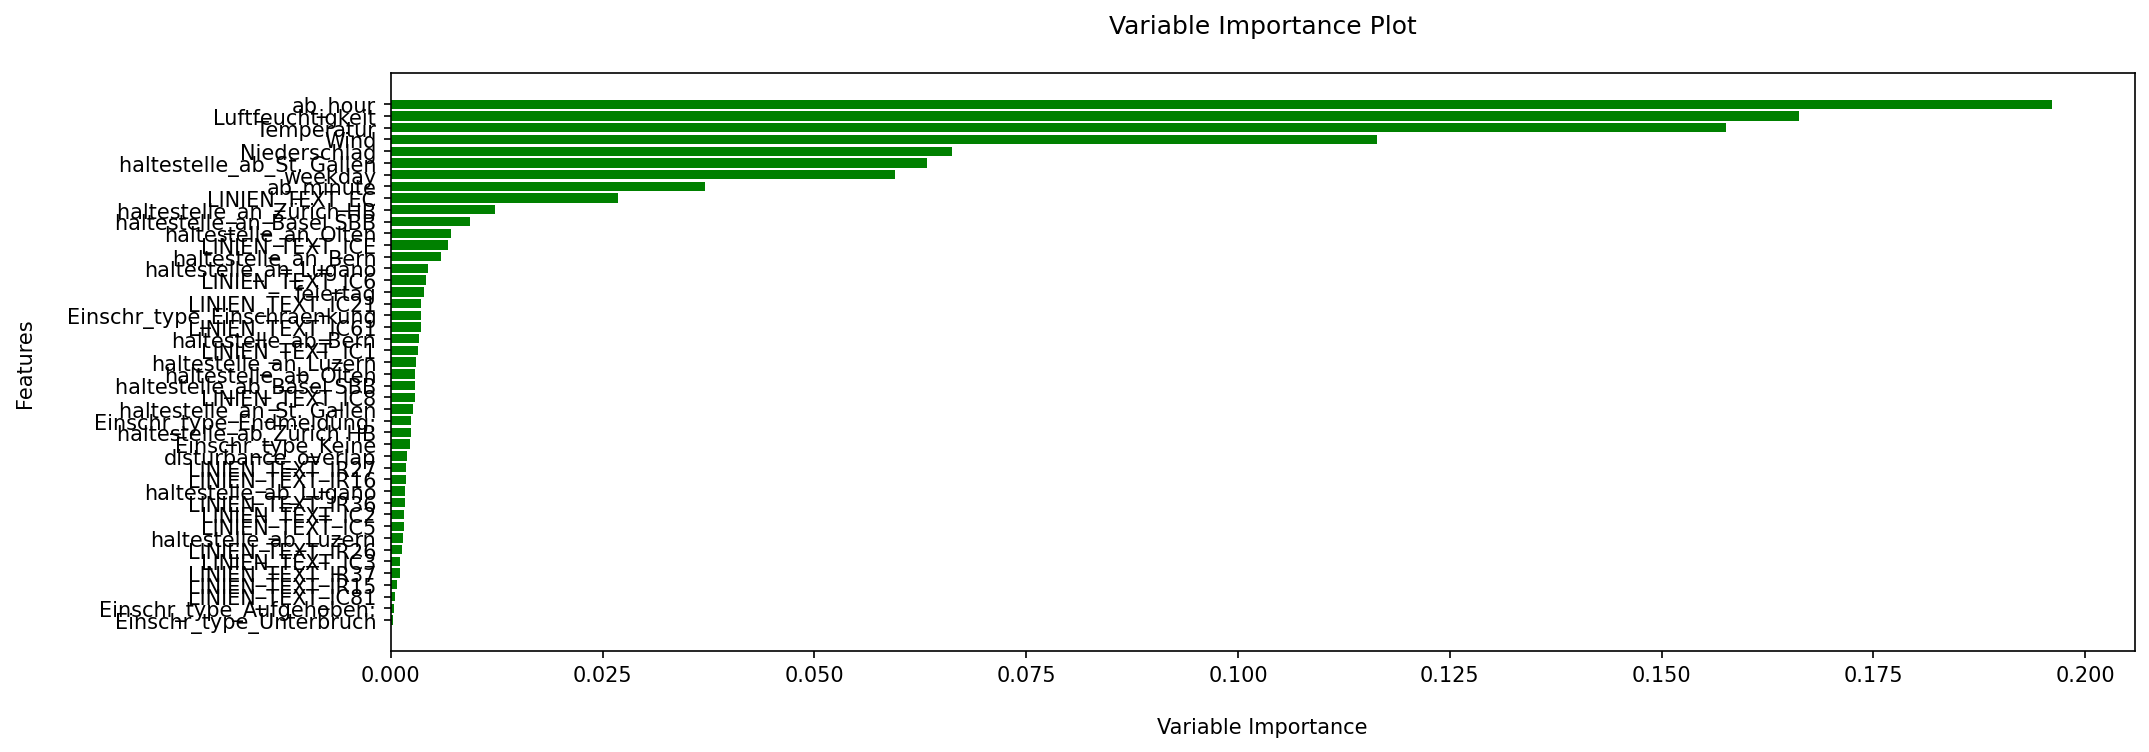

In [ ]:
def plot_variable_importance(model, X_train):
    import matplotlib.pyplot as plt
    from pandas import DataFrame
    imp=DataFrame({"imp":model.feature_importances_, "names":X_train.columns}).sort_values("imp", ascending=True)
    fig, ax = plt.subplots(figsize=(15, 5), dpi=150) 
    ax.barh(imp["names"],imp["imp"], color="green") 
    ax.set_xlabel('\nVariable Importance')
    ax.set_ylabel('Features\n') 
    ax.set_title('Variable Importance Plot\n') 
    plt.show() 

plot_variable_importance(rf, X_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the RandomForestRegressor model
rf_cv = RandomForestRegressor()

# Define the hyperparameter search space (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
params = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [3, 5, 7, 9, 11, 13, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'bootstrap': [True, False]
}

# Define the randomized search object
random_search_rf = RandomizedSearchCV(
    estimator=rf_cv,
    param_distributions=params,
    n_iter=min(60, len(params)),
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=4153
)

# Perform the randomized search
random_search_rf.fit(X_train, y_train)

# Print the best hyperparameters and corresponding evaluation metric
print(f'Best hyperparameters: {random_search_rf.best_params_}')
print(f'Best score: {random_search_rf.best_score_}')


C:\Users\stoec\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 16, 'max_features': 'auto', 'max_depth': 13, 'bootstrap': True}
Best score: -16.154703800595435


**XGBoost Regressor**

R2: 0.21
RMSE: 3.99
MAPE: 26785043386455.16


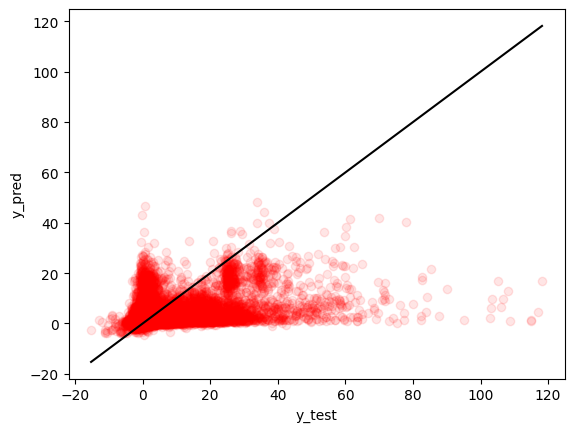

In [ ]:
# Import libraries
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4153)

# Instantiate XGBRegressor
xgb = XGBRegressor()
# Fit model
xgb.fit(X_train, y_train)

# Predict y
y_pred = xgb.predict(X_test)

# Calculate R2, RMSE and MAE
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R2: {r2:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}')

# Plot y_test and y_pred
plt.scatter(y_test, y_pred, alpha=0.1, color='red')
plt.xlabel('y_test')
plt.ylabel('y_pred')
# Calculate y_min and y_max
y_min = min(y_test.min(), y_pred.min())
y_max = max(y_test.max(), y_pred.max())
# Add line with x=y with y_min and y_max
plt.plot([y_min, y_max], [y_min, y_max], color='black')
plt.show()

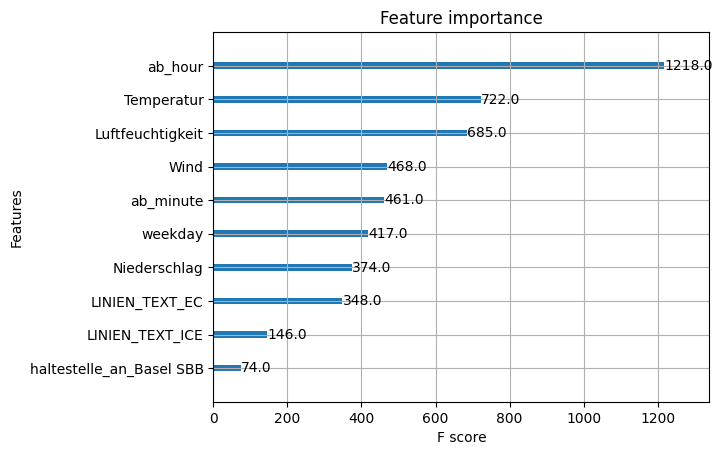

In [ ]:
# Plot feature importance
from xgboost import plot_importance
plot_importance(xgb, max_num_features=10)
plt.show()

In [ ]:
# Import libraries
from sklearn.model_selection import RandomizedSearchCV
# define the XGBoost model
xgb_cv = XGBRegressor()

# define the hyperparameter search space (https://xgboost.readthedocs.io/en/stable/python/python_api.html,
#                                         https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster)
params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.1, 0.3, 0.5, 0.7],
    'gamma': [0, 1, 5],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9, 1],  
}

# define the randomized search object
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_cv,
    param_distributions=params,
    n_iter=min(60, len(params)),
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=4153
)

# perform the randomized search
random_search_xgb.fit(X_train, y_train)

# print the best hyperparameters and corresponding evaluation metric
print(f'Best hyperparameters: {random_search_xgb.best_params_}')
print(f'Best score: {random_search_xgb.best_score_}')

Best hyperparameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.3, 'gamma': 1, 'colsample_bytree': 1}
Best score: -16.039388076422536


**Compare Models**

In [ ]:
# Import libraries
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Assuming you have X_validation and y_validation as your validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4153)
X_validation, y_validation = X_test, y_test

# Evaluate XGBoost model on the validation set
xgb_pred = random_search_xgb.predict(X_validation)
xgb_r2 = r2_score(y_validation, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_validation, xgb_pred))
xgb_mape = np.mean(np.abs((y_validation - xgb_pred) / y_validation)) * 100
print(f'XGBoost Model:')
print(f'R2 Score: {xgb_r2}')
print(f'RMSE: {xgb_rmse}')
print(f'MAPE: {xgb_mape}%')

# Evaluate RandomForestRegressor model on the validation set
rf_pred = random_search_rf.predict(X_validation)
rf_r2 = r2_score(y_validation, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_validation, rf_pred))
rf_mape = np.mean(np.abs((y_validation - rf_pred) / y_validation)) * 100
print(f'RandomForestRegressor Model:')
print(f'R2 Score: {rf_r2}')
print(f'RMSE: {rf_rmse}')
print(f'MAPE: {rf_mape}%')

# Compare the metrics and choose the best model
if xgb_rmse < rf_rmse:
    best_model = random_search_xgb.best_estimator_
    print('XGBoost Model has the lower RMSE.')
else:
    best_model = random_search_rf.best_estimator_
    print('RandomForestRegressor Model has the lower RMSE.')


XGBoost Model:
R2 Score: 0.20903912022050963
RMSE: 3.980422889778739
MAPE: inf%
RandomForestRegressor Model:
R2 Score: 0.17733890203339064
RMSE: 4.059403233751273
MAPE: inf%
XGBoost Model has the lower RMSE.


R2: 0.21
RMSE: 3.98
MAPE: 27806741089317.71


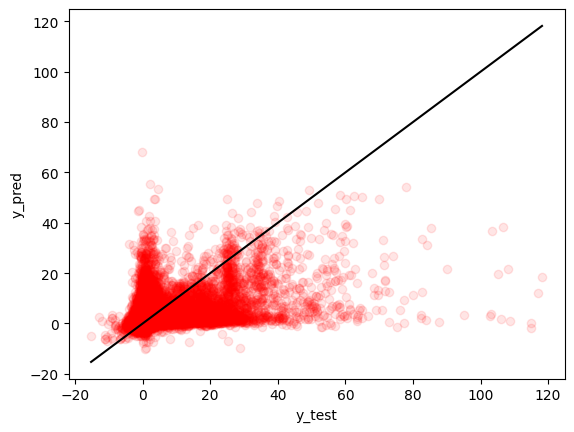

In [ ]:
# Predict y
y_pred = best_model.predict(X_test)

# Calculate R2, RMSE and MAE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R2: {r2:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}')

# Plot y_test and y_pred
plt.scatter(y_test, y_pred, alpha=0.1, color='red')
plt.xlabel('y_test')
plt.ylabel('y_pred')
# Calculate y_min and y_max
y_min = min(y_test.min(), y_pred.min())
y_max = max(y_test.max(), y_pred.max())
# Add line with x=y with y_min and y_max
plt.plot([y_min, y_max], [y_min, y_max], color='black')
plt.show()

**Export Modell**

In [ ]:
import pickle
# save model to file
pickle.dump(best_model, open("App/Modell/model_twitter.pkl", "wb"))

# save all models to files
pickle.dump(rf, open("App/Modell/rf_twitter.pkl", "wb"))
pickle.dump(xgb, open("App/Modell/xgb_twitter.pkl", "wb"))
pickle.dump(random_search_rf, open("App/Modell/random_search_rf_twitter.pkl", "wb"))
pickle.dump(random_search_xgb, open("App/Modell/random_search_xgb_twitter.pkl", "wb"))

In [ ]:
# Add again BETRIEBSTAG column
data['BETRIEBSTAG'] = betriebstage

# Save data with features
data.to_csv('App/Daten/data_expanded/data_with_features_twitter.csv', index=False)